<a href="https://colab.research.google.com/github/nagusubra/Solar_panel_dust_detection/blob/main/Final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries and modules

In [ ]:
!pip install -q tensorflow-model-optimization
!pip install openpyxl
!pip install xlsxwriter

import xlsxwriter
import openpyxl
from openpyxl import Workbook
from openpyxl.drawing.image import Image

import tempfile
from tensorflow import keras
import tensorflow_model_optimization as tfmot

from tqdm import tqdm_notebook as tqdm
import os
import time
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 10.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
import tensorflow_datasets as tfds
import zipfile

In [ ]:
# mounting google drive (if you are using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Evaluation functions

In [ ]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)
  return os.path.getsize(zipped_file)


def evaluate_model(model_path, model_info, val_dataset):

  # Evaluate test accuracy and test loss
  model = tf.keras.models.load_model(model_path)
  test_loss, test_acc = model.evaluate(val_dataset, verbose=0)

  # Evaluate Model Size
  model_size = get_gzipped_model_size(model_path)

  # Evaluate Inference Time
  startTime = time.time()
  prediction = model.predict(val_dataset)
  executionTime = (time.time() - startTime)/len(val_dataset)

  # Print
  print('\nModel Accuracy:', test_acc*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is: ", executionTime, "s")

  # Build Evalution dataframe
  evulation_dict = {
                      "Evaluation type": "Evualation",
                      "Model Information": model_info,
                      "Accuracy": str(test_acc*100) + " %",
                      "Loss": str(test_loss*100) + " %",
                      "Model Size": str(model_size) + " bytes",
                      "Inference Time": str(executionTime) + " sec"
                    }
  
  evulation_df = pd.DataFrame.from_dict(evulation_dict, orient='index').reset_index()


  return test_acc, model_size, executionTime, evulation_df

# function built for model evaluation
def evaluate_model_without_saving_stats(model, model_path, model_info, val_dataset):

  # Evaluate test accuracy and test loss
  # model = tf.keras.models.load_model(model_path)
  test_loss, test_acc = model.evaluate(val_dataset, verbose=0)

  # Evaluate Model Size
  model_size = get_gzipped_model_size(model_path)

  # Evaluate Inference Time
  startTime = time.time()
  prediction = model.predict(val_dataset)
  executionTime = (time.time() - startTime)/len(val_dataset)

  # Print
  print('\nModel Accuracy:', test_acc*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is: ", executionTime, "s")

  # Build Evalution dataframe for better view of the metrics
  evulation_dict = {
                      "Evaluation type": "Evualation",
                      "Model Information": model_info,
                      "Accuracy": str(test_acc*100) + " %",
                      "Loss": str(test_loss*100) + " %",
                      "Model Size": str(float(model_size)/10**6) + " Mega bytes", # we want mega bytes
                      "Inference Time": str(executionTime) + " sec"
                    }
  
  evulation_df = pd.DataFrame.from_dict(evulation_dict, orient='index').reset_index()


  return test_acc, model_size, executionTime, evulation_df

# research paper's evaluation function
def evaluate_research_paper_with_model_path(model_path):
  # model_path = "/content/models/solnet.hdf5"
  solnet = load_model(model_path, compile=False)
  history = solnet.history()
  plt.plot(history.history['loss'])
  plt.plot(history.history['acc'])
  plt.title('acc loss vs epoch')
  plt.xlabel('epoch')
  plt.legend(['loss', 'acc'], loc='upper left')
  plt.show()

# research paper's evaluation function
def evaluate_research_paper_with_model(model):
  history = model.history()
  plt.plot(history.history['loss'])
  plt.plot(history.history['acc'])
  plt.title('acc loss vs epoch')
  plt.xlabel('epoch')
  plt.legend(['loss', 'acc'], loc='upper left')
  plt.show()

In [ ]:
# defining the iterative prunining function to be used for model compression
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step, tdata_loader,vdata_loader, epochs):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
          final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
  pruned_model.compile(optimizer='adam',
      loss=binary_crossentropy,
      metrics=['accuracy'])

  callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(tdata_loader, epochs=epochs, validation_data=vdata_loader, callbacks=callbacks)

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  return pruned_model, stripped_pruned_model

In [ ]:
# function to verify the sparsity level for a given model
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

# Load data

The Solar panel image dataset used for the project is acquired from the research paper​​. These images were taken manually with cameras from various solar farms in Bangladesh, captured by different cameras in various sizes. This dataset was linked in the paper to a public Google Drive folder and includes 1440 solar panel images, approximately 50% of which are dirty and clean. The dataset is labeled as “clean” and “dirty” providing a binary classification. The dataset contains 718 images of dirty solar panels and 722 images of clean solar panels, providing an equal distribution for the model training. To standardize the dataset the images are taken in random sizes and augmented to a uniform dimension of [227,227,3]​. 

In [ ]:
batch_size = 32
#location = 'dataset/'
location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"
label_mode = 'binary'
seed = 10 #changed for each fold made manually

class_names = ['clean', 'dirty']
in_size = [227, 227, 3]

tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1], 
                                          subset = 'training', batch_size=batch_size, validation_split=.2)

val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1],
                                          subset = 'validation', batch_size=batch_size, validation_split=.2)

Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.


# Load research paper model and Evaluate

Since we are restrained by compute units, we had previously trained the research paper model in a seperate script and saved the model. For simplicity and project reporting purpose we are loading the model instead of training it in this notebook.

In [ ]:
research_paper_model_path = '/content/drive/MyDrive/Solar_panel_dust_detection/final_base_model/research_paper_model.h5'
research_paper_model = tf.keras.models.load_model(research_paper_model_path)

In [ ]:
research_model_test_acc, research_model_model_size, research_model_executionTime, research_model_evulation_df = evaluate_model_without_saving_stats(research_paper_model, research_paper_model_path, "#0", val_dataset)

9/9 [==============================] - 24s 38ms/step

Model Accuracy: 52.77777910232544 %
Model Size: 212498787.00 bytes
Inference Time is:  2.640246311823527 s


In [ ]:
research_model_evulation_df

,index,0
0,Evaluation type,Evualation
1,Model Information,#0
2,Accuracy,52.77777910232544 %
3,Loss,1045.3117370605469 %
4,Model Size,212.498787 Mega bytes
5,Inference Time,2.640246311823527 sec


### Observation

The reasearch paper model is ineffective with an accuracy of 53%, loss of 1045%, and inference time of 2.7 seconds. Fine-tuning was necessary to achieve improved results before compressing the model, since model compressions could on a bad performing model might worsen the final model performance. Trade-offs would need to be made, such as reducing accuracy to decrease the model size. Once appropriate metrics were achieved, we would report our findings and results.

# Load base model and Evaluate

Since we are restrained by compute units, we had previously trained the base model in a seperate script and saved the model. We have a seperate script to try various hyperparameter optmizations. For simplicity and project reporting purpose we are loading the model instead of training it in this notebook.


As discussed, measuring the base SolNet model against our evaluation metrics produced inadequate results. Therefore, our first implementation step is to fine tune the model to produce better results. 

We focused on modifying the hyperparameters of the model and training process than changing the core architecture of SolNet itself. The rationale for this decision is due to the constrained limitations of the compute resources we possess and the time constraints due to academic commitments. We approached this problem through an iterative trial and error approach. By iterating through configurations of hyperparameters and recording suitable performance metrics, we were able to fine-tune the model without changing its core architecture. 

We lowered the learning rate to 0.00001 which is a 10x decrease from the research paper model.  As well as increasing the epoch count from 30 epochs to 40 epochs which is fitting for the lower learning rate.  We maintained the batch and image size as it did not provide better performance. Another modification we made was removing the beta parameters from the Adam optimizer of the model. These resulted in improved performance.

In [ ]:
base_model_path = '/content/drive/MyDrive/Solar_panel_dust_detection/final_base_model/final_base_model_2.h5'
base_model = tf.keras.models.load_model(base_model_path)

In [ ]:
base_model_test_acc, base_model_model_size, base_model_executionTime, base_model_evulation_df = evaluate_model_without_saving_stats(base_model, base_model_path, "#0", val_dataset)

9/9 [==============================] - 26s 42ms/step

Model Accuracy: 94.44444179534912 %
Model Size: 645039747.00 bytes
Inference Time is:  2.8471626705593533 s


In [ ]:
 base_model_evulation_df

,index,0
0,Evaluation type,Evualation
1,Model Information,#0
2,Accuracy,94.44444179534912 %
3,Loss,17.469173669815063 %
4,Model Size,645.039747 Mega bytes
5,Inference Time,2.8471626705593533 sec


# Iteratively prune model and Evaluate



In [ ]:
# Iterative pruning calculations: 
# frquency = 100
# target sparsity = 75%
# sparisty for each pruning tep = 75%/100 = 0.75%
# Total Number of Training Samples = 1440
# batch size = 32
# epochs = 25

# possible start and end for the iterative pruning schedule
# Number of learning steps = (1440/32)*25 = 1125 (110, 1010) -> chosen epoch of 25 epochs

# iterative_pruning(
                  #     model, 
                  #     initial_sparsity = 0, 
                  #     final_sparsity   = 0.75, 
                  #     begin_step       = 0, 110  (~10% of 1440) # pruning early on the pruning schedule to get optimal model size
                  #     end_step         = ?, 1010 (~90% of 1440) # pruning only till 90% so that model can still have enough leanring steps to learn and build networks for the data
                  #     train_images, 
                  #     train_labels, 
                  #     epochs           = 25
                  # )

iteratively_pruned_model, iteratively_pruned_stripped_model = iterative_pruning(base_model, 0, 0.75, 110, 1010, tr_dataset, val_dataset, 25)

Epoch 1/25
36/36 [==============================] - 179s 4s/step - loss: 11.0862 - accuracy: 0.7040 - val_loss: 3309.9558 - val_accuracy: 0.4722
Epoch 2/25
36/36 [==============================] - 120s 3s/step - loss: 3.2252 - accuracy: 0.7656 - val_loss: 365.0758 - val_accuracy: 0.4722
Epoch 3/25
36/36 [==============================] - 120s 3s/step - loss: 1.5562 - accuracy: 0.8359 - val_loss: 18.5284 - val_accuracy: 0.4236
Epoch 4/25
36/36 [==============================] - 122s 3s/step - loss: 1.1703 - accuracy: 0.8325 - val_loss: 12.0849 - val_accuracy: 0.6215
Epoch 5/25
36/36 [==============================] - 121s 3s/step - loss: 0.8665 - accuracy: 0.8594 - val_loss: 47.0867 - val_accuracy: 0.5556
Epoch 6/25
36/36 [==============================] - 122s 3s/step - loss: 0.7667 - accuracy: 0.8325 - val_loss: 1.6513 - val_accuracy: 0.5972
Epoch 7/25
36/36 [==============================] - 121s 3s/step - loss: 0.4741 - accuracy: 0.8628 - val_loss: 0.9617 - val_accuracy: 0.8958
Epoc

In [ ]:
# saving the model

iteratively_pruned_model_path = "iteratively_pruned_model.h5"
iteratively_pruned_stripped_model.save(iteratively_pruned_model_path)


iteratively_pruned_model.save('/content/drive/MyDrive/Solar_panel_dust_detection/final_base_model/iteratively_pruned_75_model.h5')
iteratively_pruned_stripped_model.save('/content/drive/MyDrive/Solar_panel_dust_detection/final_base_model/iteratively_stripped_pruned_75_model.h5')

In [ ]:
pruned_test_acc, pruned_model_size, pruned_executionTime, pruned_evulation_df = evaluate_model_without_saving_stats(iteratively_pruned_model, iteratively_pruned_model_path, "#1", val_dataset)

9/9 [==============================] - 26s 36ms/step

Model Accuracy: 96.875 %
Model Size: 80363019.00 bytes
Inference Time is:  2.912324481540256 s


In [ ]:
# verifying the sparsity of the model after iterative pruning
print_model_weights_sparsity(iteratively_pruned_model)

conv2d/kernel:0: 74.18% sparsity  (25849/34848)
conv2d_1/kernel:0: 74.18% sparsity  (455743/614400)
conv2d_2/kernel:0: 74.18% sparsity  (656270/884736)
conv2d_3/kernel:0: 74.18% sparsity  (984405/1327104)
conv2d_4/kernel:0: 74.18% sparsity  (656270/884736)
dense/kernel:0: 74.18% sparsity  (28000863/37748736)
dense_1/kernel:0: 74.18% sparsity  (12444828/16777216)
dense_2/kernel:0: 74.17% sparsity  (3038/4096)


In [ ]:
pruned_evulation_df

,index,0
0,Evaluation type,Evualation
1,Model Information,#1
2,Accuracy,96.875 %
3,Loss,9.209202229976654 %
4,Model Size,80.363019 Mega bytes
5,Inference Time,2.912324481540256 sec


## Observation


| Base model | Iteratively pruned model|
|------------|------------|
| - Overall accuracy: 96.18%| - Overall accuracy: 96.87% (higher accuracy)|
| - Overall model size: 648.7 MB | - Overall model size: 80.36 MB (smaller size)|
| - Overall Inference time: 4.56 s | - Overall Inference time: 2.91 s (lower inference time)|
| - Performance: Lower| - Performance: Higher|
| - Key: It has a larger model size compared to iterative pruning,| - Key: Iterative pruning proves that we can fine tune our sparsity level, |
|  and significanlty has higher inference time.| while maintaining our accuracy and inference time.|


In terms of fine-tuning, after modifying the hyperparameters the best result we managed to achieve was an accuracy of 96 %. This is around a 44% boost from the 52% prior to research paper model tuning. We also had a model size of around 650 MB. This was much larger than the original model which was around 212 MB. We also halved the inference time, a reduction of around 4.5 seconds from the research paper model. Overall, we were content with these results as we fixed the primary issue of low accuracy. However, from here we knew some more work had to be done to compress the model to acceptable standards. 

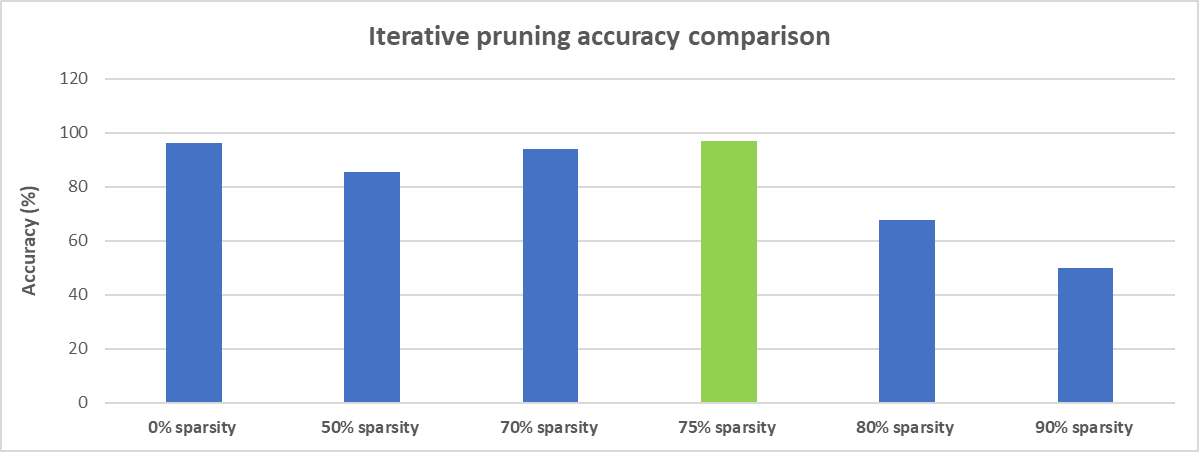

50% sparsity

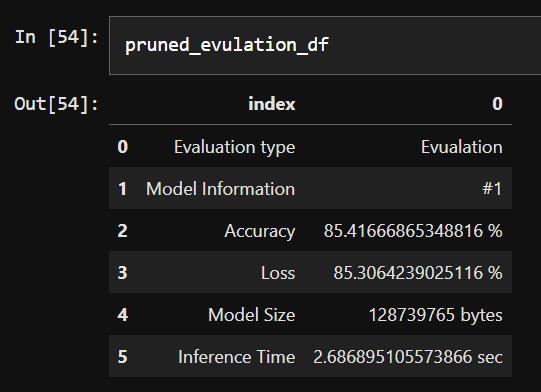

70% sparsity:

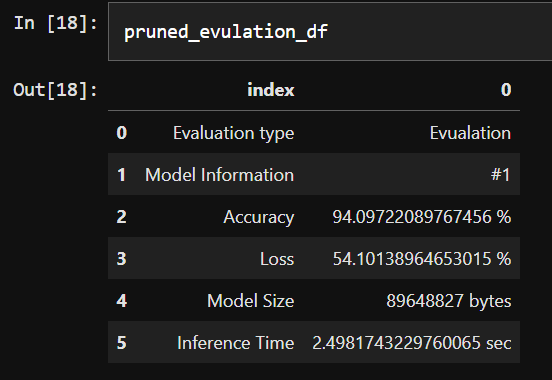



90 % sparsity

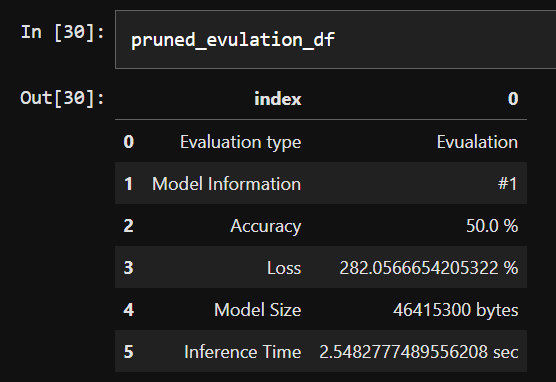

# Quantization

In [ ]:
# A helper function to evaluate the TF Lite model using a test loader.
def evaluate_tflite_model(interpreter, model_path, test_loader):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the test dataset.
  prediction_digits = []
  accurate_count = 0
  total_images = 0
  total_time = 0

  for images, labels in val_dataset:
    total_images += len(images)
    for i in range(len(images)):
      # Pre-processing: add batch dimension and convert to float32 to match with
      # the model's input data format.
      test_image = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)
      interpreter.set_tensor(input_index, test_image)

      # Run inference.
      startTime = time.time()
      interpreter.invoke()
      executionTime = time.time() - startTime
      total_time += executionTime

      # Post-processing: remove batch dimension and find the digit with highest
      # probability.
      interpreter.invoke()
      output = interpreter.get_tensor(output_index)

      digit = np.round(output[0])
      prediction_digits.append(digit)

      # Compare prediction results with ground truth labels to calculate accuracy.
      if digit == labels[i].numpy():
        accurate_count += 1

  accuracy = accurate_count * 1.0 / total_images
  model_size = get_gzipped_model_size(model_path)

  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Average Inference Time per Image: %.5f s" % (total_time/total_images))

  # Build Evalution dataframe
  evulation_dict = {
                      "Evaluation type": "Evualation",
                      "Accuracy": str(accuracy*100) + " %",
                      "Model Size": str(float(model_size)/10**6) + " Mega bytes", # we want mega bytes
                      "Average Inference Time per Image": str((total_time/total_images)) + " sec"
                    }
  
  evulation_df = pd.DataFrame.from_dict(evulation_dict, orient='index').reset_index()
  
  return evulation_df

## Base model

### 32 bit quanitization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]
fp32_quantized_tflite_base_model = converter.convert()

with open('fp32_quantized_tflite_base_model.tflite', 'wb') as f:
  f.write(fp32_quantized_tflite_base_model)
interpreter_fp32_quant_base_model = tf.lite.Interpreter(model_path=str('fp32_quantized_tflite_base_model.tflite'))
interpreter_fp32_quant_base_model.allocate_tensors()

In [ ]:
quantized_32_bit_tflite_base_model_evulation_df = evaluate_tflite_model(interpreter_fp32_quant_base_model, 'fp32_quantized_tflite_base_model.tflite', val_dataset)
quantized_32_bit_tflite_base_model_evulation_df


Model Accuracy: 88.88888888888889 %
Model Size: 78731271.00 bytes
Average Inference Time per Image: 0.07895 s


,index,0
0,Evaluation type,Evualation
1,Accuracy,88.88888888888889 %
2,Model Size,78.731271 Mega bytes
3,Average Inference Time per Image,0.07895166012975904 sec


### 16 bit quanitization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
fp16_quantized_tflite_base_model = converter.convert()

with open('fp16_quantized_tflite_base_model.tflite', 'wb') as f:
  f.write(fp16_quantized_tflite_base_model)
interpreter_fp16_quant_base_model = tf.lite.Interpreter(model_path=str('fp16_quantized_tflite_base_model.tflite'))
interpreter_fp16_quant_base_model.allocate_tensors()

In [ ]:
quantized_16_bit_tflite_base_model_evulation_df = evaluate_tflite_model(interpreter_fp16_quant_base_model, 'fp16_quantized_tflite_base_model.tflite', val_dataset)
quantized_16_bit_tflite_base_model_evulation_df


Model Accuracy: 88.88888888888889 %
Model Size: 44957703.00 bytes
Average Inference Time per Image: 0.07796 s


,index,0
0,Evaluation type,Evualation
1,Accuracy,88.88888888888889 %
2,Model Size,44.957703 Mega bytes
3,Average Inference Time per Image,0.07795967078871197 sec


### 8 bit quanitization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
fp8_quantized_tflite_base_model = converter.convert()

with open('fp8_quantized_tflite_base_model.tflite', 'wb') as f:
  f.write(fp8_quantized_tflite_base_model)
interpreter_fp8_quant_base_model = tf.lite.Interpreter(model_path=str('fp8_quantized_tflite_base_model.tflite'))
interpreter_fp8_quant_base_model.allocate_tensors()

In [ ]:
quantized_8_bit_tflite_base_model_evulation_df = evaluate_tflite_model(interpreter_fp8_quant_base_model, 'fp8_quantized_tflite_base_model.tflite', val_dataset)
quantized_8_bit_tflite_base_model_evulation_df


Model Accuracy: 89.93055555555556 %
Model Size: 22582982.00 bytes
Average Inference Time per Image: 0.06260 s


,index,0
0,Evaluation type,Evualation
1,Accuracy,89.93055555555556 %
2,Model Size,22.582982 Mega bytes
3,Average Inference Time per Image,0.06260265823867586 sec


## Pruned model

### 32 bit quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(iteratively_pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]
fp16_quantized_tflite_iteratively_pruned_model = converter.convert()

with open('fp32_quantized_tflite_iteratively_pruned_model.tflite', 'wb') as f:
  f.write(fp16_quantized_tflite_iteratively_pruned_model)
interpreter_fp32_quant_iteratively_pruned_model = tf.lite.Interpreter(model_path=str('fp32_quantized_tflite_iteratively_pruned_model.tflite'))
interpreter_fp32_quant_iteratively_pruned_model.allocate_tensors()

In [ ]:
quantized_32_bit_tflite_iteratively_pruned_model_evulation_df = evaluate_tflite_model(interpreter_fp32_quant_iteratively_pruned_model, 'fp32_quantized_tflite_iteratively_pruned_model.tflite', val_dataset)
quantized_32_bit_tflite_iteratively_pruned_model_evulation_df


Model Accuracy: 96.875 %
Model Size: 92709030.00 bytes
Average Inference Time per Image: 0.41026 s


,index,0
0,Evaluation type,Evualation
1,Accuracy,96.875 %
2,Model Size,92.70903 Mega bytes
3,Average Inference Time per Image,0.4102597220076455 sec


### 16 bit quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(iteratively_pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
fp16_quantized_tflite_iteratively_pruned_model = converter.convert()

with open('fp16_quantized_tflite_iteratively_pruned_model.tflite', 'wb') as f:
  f.write(fp16_quantized_tflite_iteratively_pruned_model)
interpreter_fp16_quant_iteratively_pruned_model = tf.lite.Interpreter(model_path=str('fp16_quantized_tflite_iteratively_pruned_model.tflite'))
interpreter_fp16_quant_iteratively_pruned_model.allocate_tensors()

In [ ]:
quantized_16_bit_tflite_iteratively_pruned_model_evulation_df = evaluate_tflite_model(interpreter_fp16_quant_iteratively_pruned_model, 'fp16_quantized_tflite_iteratively_pruned_model.tflite', val_dataset)
quantized_16_bit_tflite_iteratively_pruned_model_evulation_df


Model Accuracy: 96.875 %
Model Size: 56643550.00 bytes
Average Inference Time per Image: 0.41989 s


,index,0
0,Evaluation type,Evualation
1,Accuracy,96.875 %
2,Model Size,56.64355 Mega bytes
3,Average Inference Time per Image,0.4198939460847113 sec


### 8 bit quantization

In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(iteratively_pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
fp8_quantized_tflite_iteratively_pruned_model = converter.convert()

with open('fp8_quantized_tflite_iteratively_pruned_model.tflite', 'wb') as f:
  f.write(fp8_quantized_tflite_iteratively_pruned_model)
interpreter_fp8_quant_iteratively_pruned_model = tf.lite.Interpreter(model_path=str('fp8_quantized_tflite_iteratively_pruned_model.tflite'))
interpreter_fp8_quant_iteratively_pruned_model.allocate_tensors()

In [ ]:
quantized_8_bit_tflite_iteratively_pruned_model_evulation_df = evaluate_tflite_model(interpreter_fp8_quant_iteratively_pruned_model, 'fp8_quantized_tflite_iteratively_pruned_model.tflite', val_dataset)
quantized_8_bit_tflite_iteratively_pruned_model_evulation_df


Model Accuracy: 96.875 %
Model Size: 92709052.00 bytes
Average Inference Time per Image: 0.42671 s


,index,0
0,Evaluation type,Evualation
1,Accuracy,96.875 %
2,Model Size,92.709052 Mega bytes
3,Average Inference Time per Image,0.426711773706807 sec


## Observation

Based on the results, we can observe that the quantization with 32-bit, 16-bit and 8-bit effectively maintains the accuracy of the model prior to quantization. We do notice that the base model suffers around 8% loss in accuracy due to 32/16/8-bit quantization. We observed that the size reduction of the 32-bit base model is 87.9% smaller than the base model and 8-bit base model is 96.6% smaller than the base model. The pruned model results in much better accuracy, the accuracy is almost equivalent to the base model at 96.9%. We observed that the 32-bit and 8-bit pruned model is around 14.4% larger than the 75% pruned model and 8-bit pruned model is about 30% smaller than the 75% pruned model.  

Hence, we will be choosing the 16-bit, 75% pruned model as our final model since it resulted in a smaller size than the other quantization levels while maintaining the accuracy. 

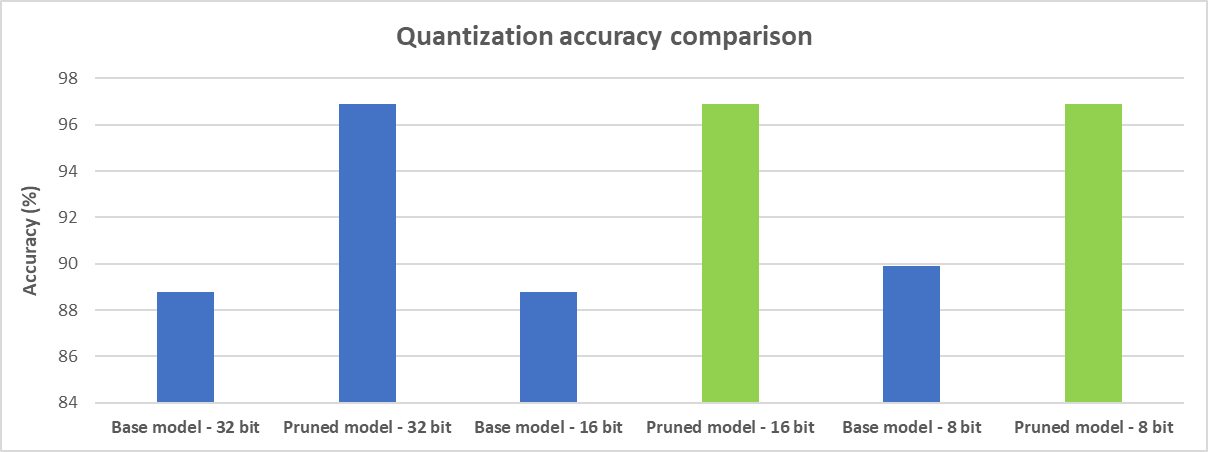

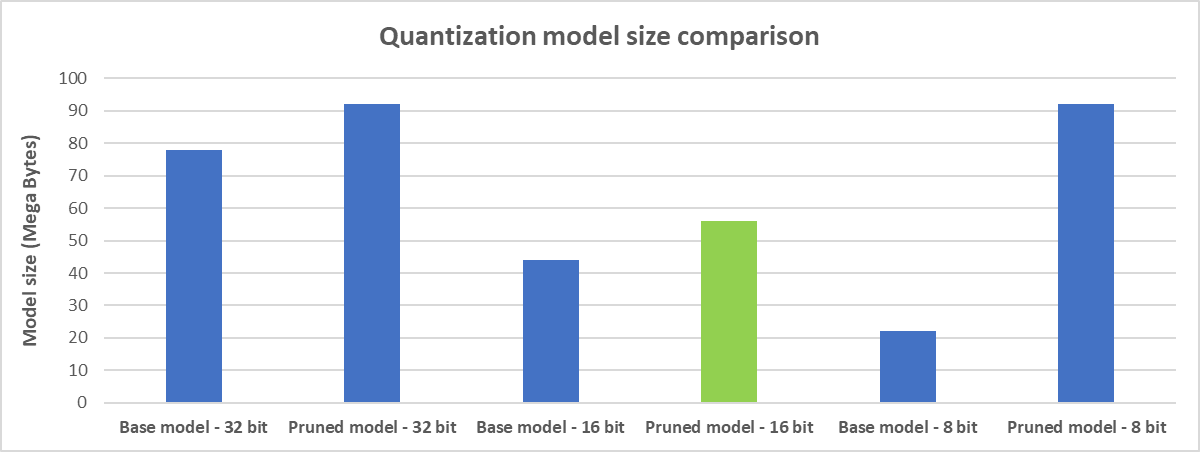

## Conclusion

The 16-bit quantization of the model produced the smallest model size without a significant reduction in accuracy. Through this all our metrics stayed around the same except for our model size which went down to just 56 MB.

Table 4: Model comparison table

| **Evaluation** | **Research paper model (SolNet model)** | **Tuned Model** | **Final Model** |
| --- | --- | --- | --- |
| **Accuracy** | 52.77 % | **96.18 %** | **96.88 %** |
| **Model Size** | 212.5 MB | **648.7 MB** | **56.5 MB** |
| **Inference Time** | 9.12 sec | **4.56 sec** | **0.42 sec** |

We can see our final model's performance metrics are 96% accuracy, 56 MB model size, and 0.42 seconds inference time. These are significant improvements from the model we started off with. Overall, we have achieved our goals for this project based on these metrics.
